# Experiment with the mnist fashion data set

It is very similar to the mnist digit data set.  It has 10 categories of black and white images. 

* 0 = t-shirt
* 1 = trouser
* 2 = pullover
* 3 = dress
* 4 = coat
* 5 = sandal
* 6 = shirt
* 7 = sneaker
* 8 = bag
* 9 = ankle boot

In [1]:
from aitk.utils import gallery, array_to_image
from aitk.networks import Network

import tensorflow
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

# Get the data
* Download the data
* Explore what you have

In [2]:
(train_x, train_y), (test_x, test_y) = fashion_mnist.load_data()

In [3]:
train_x.shape

(60000, 28, 28)

In [4]:
test_x.shape

(10000, 28, 28)

In [5]:
images = [array_to_image(train_x[i]) for i in range(20)]

In [6]:
gallery(images)

0,1,2,3,4
5,6,7,8,9
10,11,12,13,14
15,16,17,18,19


In [7]:
train_y[:20]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4],
      dtype=uint8)

# Prepare the data for the network
* You may need to normalize the inputs so that they are in the range [0,1].
* You may need to convert the targets so that they are represented as one-hot vectors when you are doing categorization.

### Input data

In [8]:
min_input = train_x.min()
max_input = train_x.max()
print("range of input values is:", min_input, max_input)

range of input values is: 0 255


In [9]:
train_x_normalized = (train_x - min_input) / float(max_input-min_input)

In [10]:
test_x_normalized = (test_x - min_input) / float(max_input-min_input)

### Data sent into a Conv2D layer must have a depth
* This may require you to do a reshape command.
* For these black and white images there is only one channel of information.
* For color images there are typically 3 channels (Red, Green, Blue)

In [11]:
train_x_normalized = train_x_normalized.reshape(60000,28,28,1)
test_x_normalized = test_x_normalized.reshape(10000,28,28,1)

### Target data

In [12]:
num_categories = len(set(train_y))

In [13]:
train_y_category = to_categorical(train_y, num_categories)

In [14]:
test_y_category = to_categorical(test_y, num_categories)

In [15]:
train_y_category[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

# Construct the model

This is just one possible configuration of layers to learn the MNIST data set.  Feel free to experiment with the number of filters, the filter size, and the layers themselves.

In [36]:
neural_net = Sequential()
neural_net.add(Conv2D(32,(3,3),activation="relu",padding='same',input_shape=(28,28,1)))
neural_net.add(Conv2D(64,(3,3),activation="relu"))
neural_net.add(Conv2D(128,(3,3),activation="relu"))
neural_net.add(Flatten())
neural_net.add(Dense(128, activation='relu'))
neural_net.add(Dense(10, activation='softmax'))
neural_net.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 128)       73856     
                                                                 
 flatten_4 (Flatten)         (None, 73728)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               9437312   
                                                                 
 dense_9 (Dense)             (None, 10)                1290      
                                                                 
Total params: 9,531,274
Trainable params: 9,531,274
No

# Compile the model

For our XOR networks we defined loss as sum-squared error.  However, for categorical data like handwritten digits it is better to use a different loss function called *categorical_crossentropy*.  This interprets the outputs as representing probabilities and forces them to sum to 1.0.  Thus the output from the network will reflect how likely it considers a particular input to be a member of one of the output categories.

In [37]:
neural_net.compile(optimizer="SGD", loss="categorical_crossentropy",
                   metrics=['accuracy'])

# Create an aitk Network
This allows us to do more visualization of what is happening inside the network.

In [38]:
net = Network(neural_net)

In [39]:
from time import sleep
for i in range(10):
    net.propagate(train_x_normalized[i])
    net.display(train_x_normalized[i])
    sleep(1.0)

# Train the model

In [35]:
history = net.fit(train_x_normalized, 
                  train_y_category, 
                  verbose=1,
                  validation_data=(test_x_normalized, 
                                   test_y_category),
                  epochs=10)

Epoch 10/10 loss: 0.23323121666908264 - accuracy: 0.9147499799728394 - val_loss: 0.2961716949939728 - val_accuracy: 0.892799973487854


# Inspect the feature maps

We can ask the network to propagate to specific layers and inspect the representations created there to try to understand how it has solved the problem.

channel0,channel1,channel2,channel3,channel4,channel5,channel6,channel7

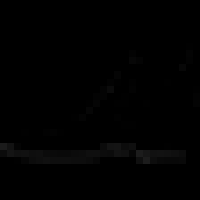
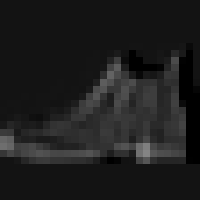
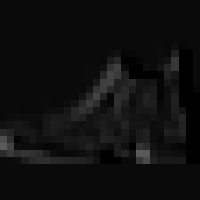
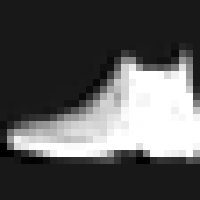
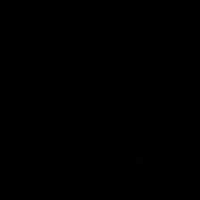
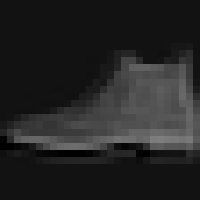
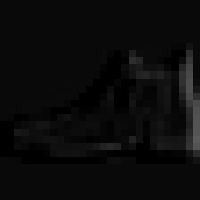
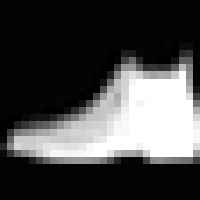

In [21]:
images = [net.propagate_to(test_x_normalized[0], "conv2d", "image", channel=channel)
         for channel in range(8)]
bigger = [image.resize((200,200),resample=0) for image in images]
gallery(bigger, labels="channel{index}", gallery_shape=(8,1))

In [31]:
images = [net.propagate_to(test_x_normalized[0], "max_pooling2d", "image", channel=channel)
         for channel in range(8)]
bigger = [image.resize((200,200),resample=0) for image in images]
gallery(bigger, labels="channel{index}", gallery_shape=(8,1))

KeyError: 'max_pooling2d'

# Examine the results
Check which inputs the network is getting wrong. Recall that there are 10 thousand test images.

In [32]:
from numpy import argmax
outputs = net.predict(test_x_normalized)
answers = [argmax(output) for output in outputs]
targets = [argmax(target) for target in test_y_category]

2022-03-31 21:57:47.481974: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 957.03MiB (rounded to 1003520000)requested by op Conv2D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-03-31 21:57:47.482053: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-03-31 21:57:47.482086: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 37, Chunks in use: 34. 9.2KiB allocated for chunks. 8.5KiB in use in bin. 712B client-requested in use in bin.
2022-03-31 21:57:47.482107: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2022-03-31 21:57:47.482126: I tensorfl

Exception: You must supply the inputs for these banks in order and in the right shape: conv2d_input: [(None, 28, 28, 1)]

.cc:1066] InUse at 7f21fc002600 of size 256 next 39
2022-03-31 21:57:47.482921: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7f21fc002700 of size 256 next 40
2022-03-31 21:57:47.482933: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7f21fc002800 of size 256 next 41
2022-03-31 21:57:47.482944: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7f21fc002900 of size 256 next 42
2022-03-31 21:57:47.482956: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7f21fc002a00 of size 256 next 43
2022-03-31 21:57:47.482968: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7f21fc002b00 of size 256 next 44
2022-03-31 21:57:47.482980: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7f21fc002c00 of size 256 next 45
2022-03-31 21:57:47.482992: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7f21fc002d00 of size 256 next 48
2022-03-31 21:57:47.483004: I tensorflow/core/common_runtime/bfc_a

In [ ]:
incorrect = [i for i in range(len(answers)) if answers[i] != targets[i]]
len(incorrect)

In [ ]:
right_ans = [targets[i] for i in incorrect]
wrong_ans = [answers[i] for i in incorrect]
label = [str(right_ans[i]) + "," + str(wrong_ans[i]) for i in range(len(right_ans))]

In [ ]:
images = [array_to_image(test_x[index]) for index in incorrect]
gallery(images, labels=label)